In [23]:
library(Hmisc)

Warning message:
"package 'Hmisc' was built under R version 3.6.3"Loading required package: lattice
Loading required package: survival
Warning message:
"package 'survival' was built under R version 3.6.3"Loading required package: Formula
Warning message:
"package 'Formula' was built under R version 3.6.3"Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, units



### Read data

In [157]:
df = read.table("airlines_passengers_data.csv",sep=',',header=1)

In [158]:
head(df)

Month,Passengers
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
1949-06,135


In [159]:
describe(df)

df 

 2  Variables      144  Observations
--------------------------------------------------------------------------------
Month 
       n  missing distinct 
     144        0      144 

lowest : 1949-01 1949-02 1949-03 1949-04 1949-05
highest: 1960-08 1960-09 1960-10 1960-11 1960-12
--------------------------------------------------------------------------------
Passengers 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
     144        0      118        1    280.3    135.9    121.6    135.3 
     .25      .50      .75      .90      .95 
   180.0    265.5    360.5    453.2    488.1 

lowest : 104 112 114 115 118, highest: 535 548 559 606 622
--------------------------------------------------------------------------------

In [160]:
yr <- substr(df$Month,1,4)
mo <- substr(df$Month,6,7)
dates <- as.Date(paste(yr,mo,'01',sep="-"))

In [161]:
df_2 = zoo(df$Passengers,order.by=dates)

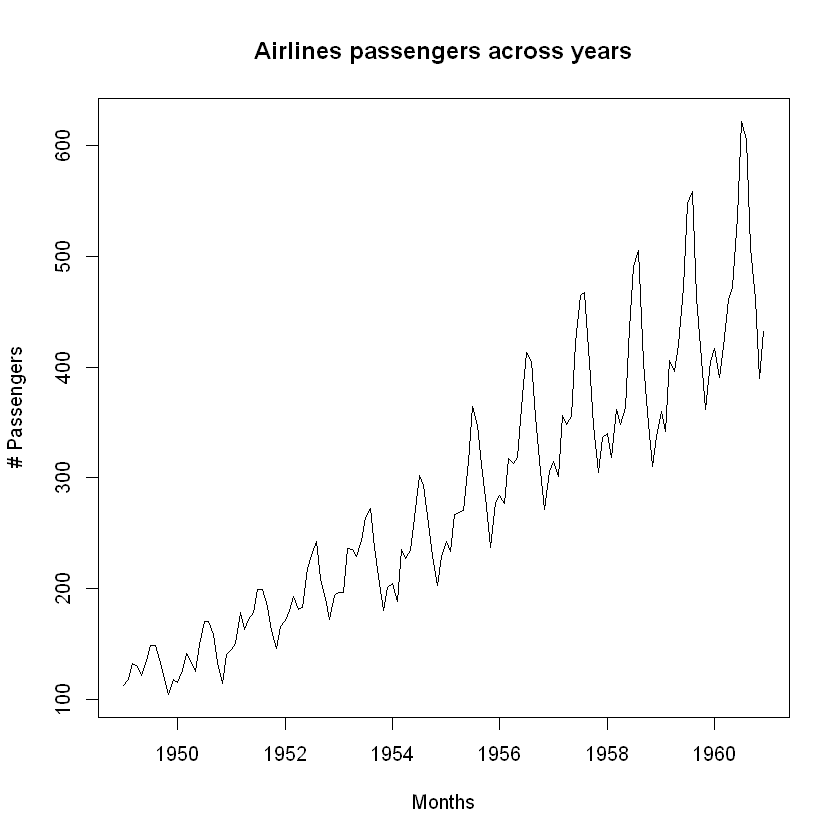

In [166]:
plot(df_2,xlab="Months",ylab="# Passengers",main="Airlines passengers across years")

In [167]:
# take log to remove increasing variance in seasonality
df_2_log = zoo(log(df$Passengers),order.by=dates)

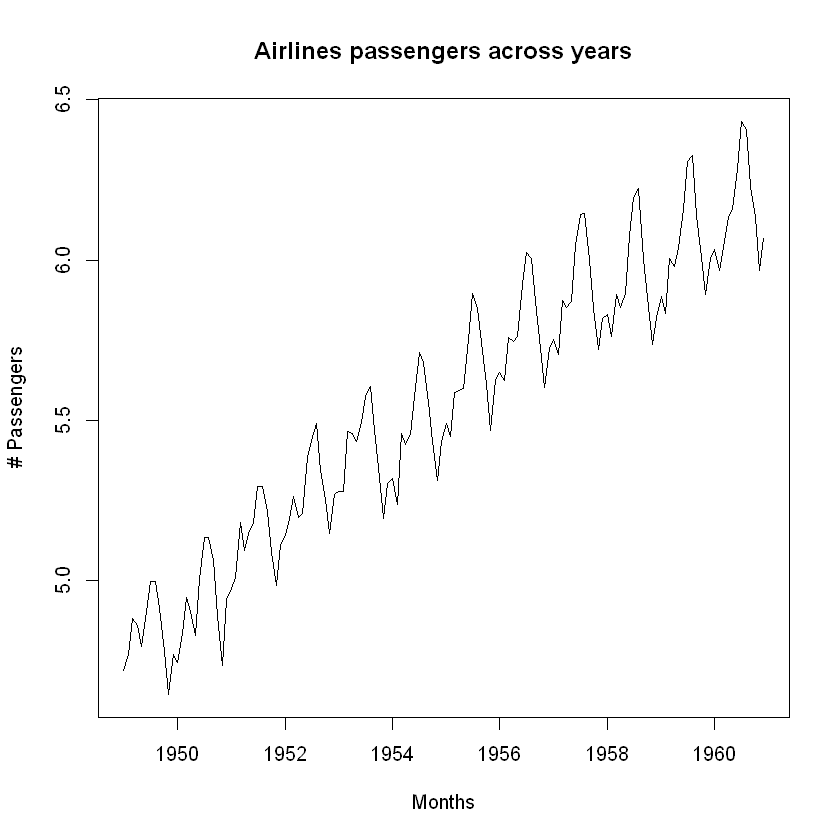

In [168]:
plot(df_2_log,xlab="Months",ylab="# Passengers",main="Airlines passengers across years")

### Spectral Analysis

ERROR: Error in lenght(df$Passengers): could not find function "lenght"


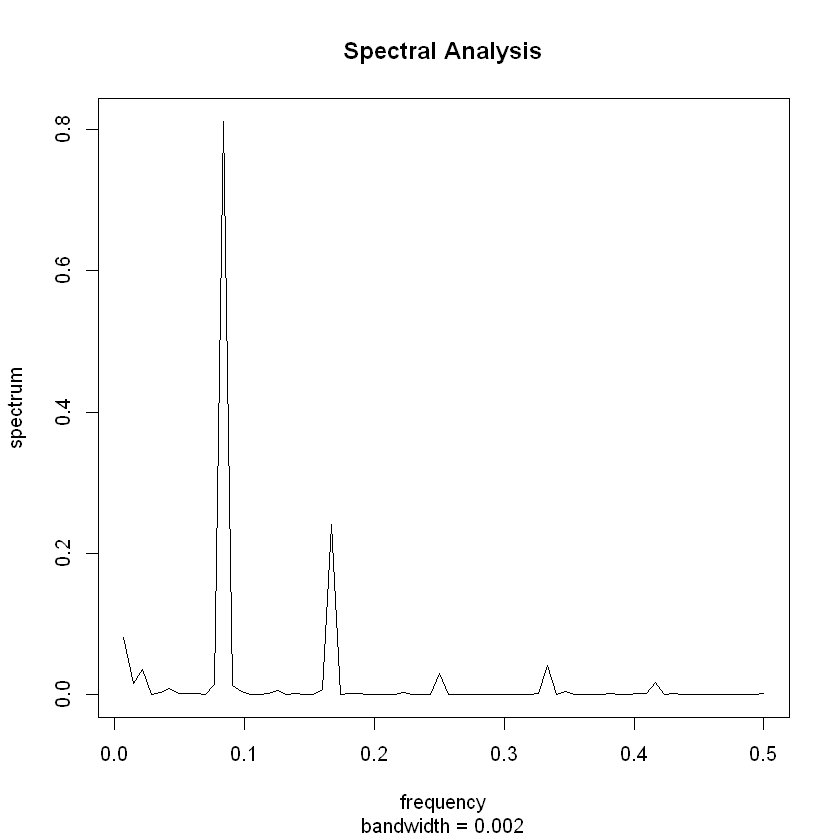

In [323]:
density_spectrum <- spectrum(log(df$Passengers),log='no',main="Spectral Analysis",taper=0)
n = lenght(df$Passengers)

The frequency is number of cycles per observations, this is equivalent to cycles per month in this case.

We can convert this to cycles per quarter or cycles per year as well.

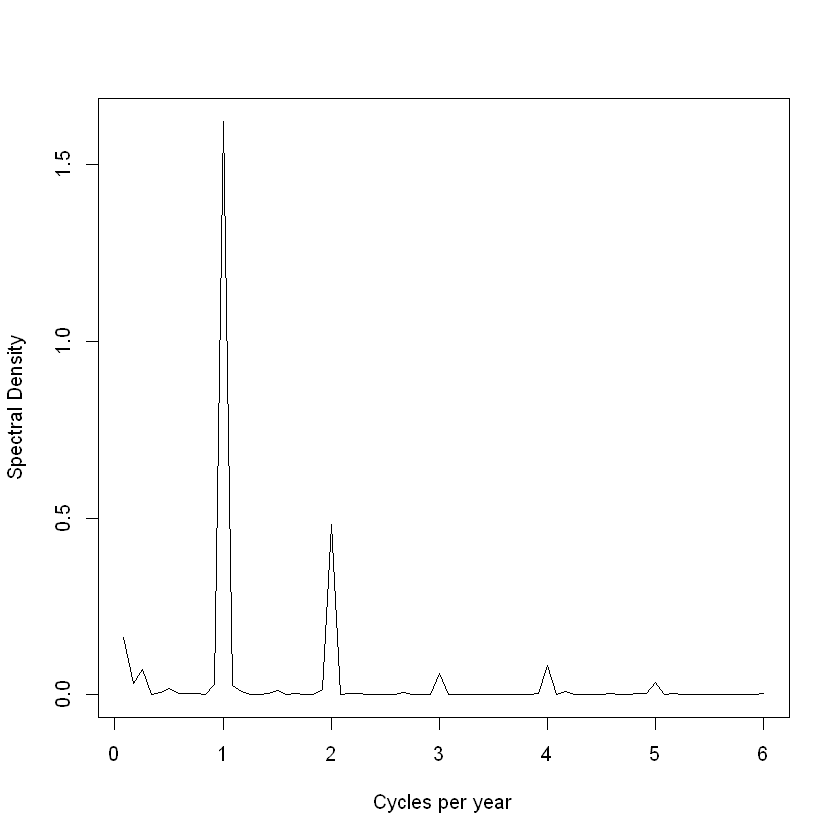

In [324]:
# frequency as cycles per year
sampling_freq = 12
spec_freq = density_spectrum$freq * sampling_freq
spec_perdiodogram = 2 * density_spectrum$spec
plot(spec_freq, spec_perdiodogram, xlab="Cycles per year", ylab="Spectral Density", type="l")

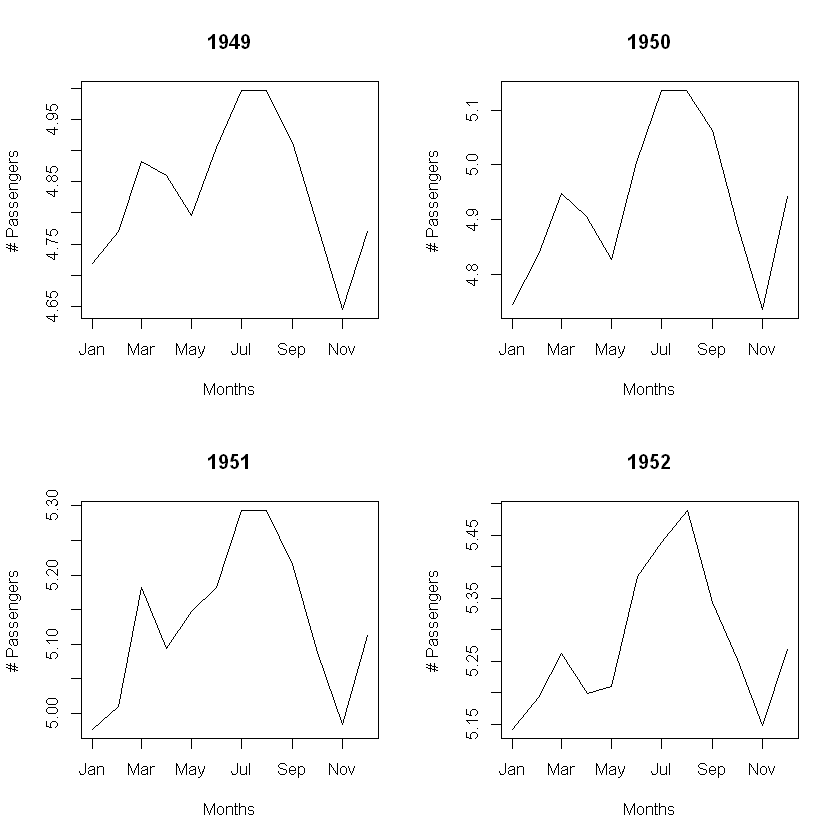

In [219]:
par(mfrow=c(2,2))
plot(df_2_log[1:12],xlab="Months",ylab="# Passengers",main=min(yr[1:12]))
plot(df_2_log[13:24],xlab="Months",ylab="# Passengers",main=min(yr[13:24]))
plot(df_2_log[25:36],xlab="Months",ylab="# Passengers",main=min(yr[25:36]))
plot(df_2_log[37:48],xlab="Months",ylab="# Passengers",main=min(yr[37:48]))

### Calculating Periodogram by hand

In [362]:
library(pracma)
df_detrend = data.frame("Passengers"=detrend(log(df$Passengers), 'linear'))
head(df_detrend)

Passengers
-0.105217793
-0.063080421
0.038988495
0.005950595
-0.068119645
0.031316206


In [363]:
df_detrend = zoo(df_detrend$Passengers,order.by=dates)

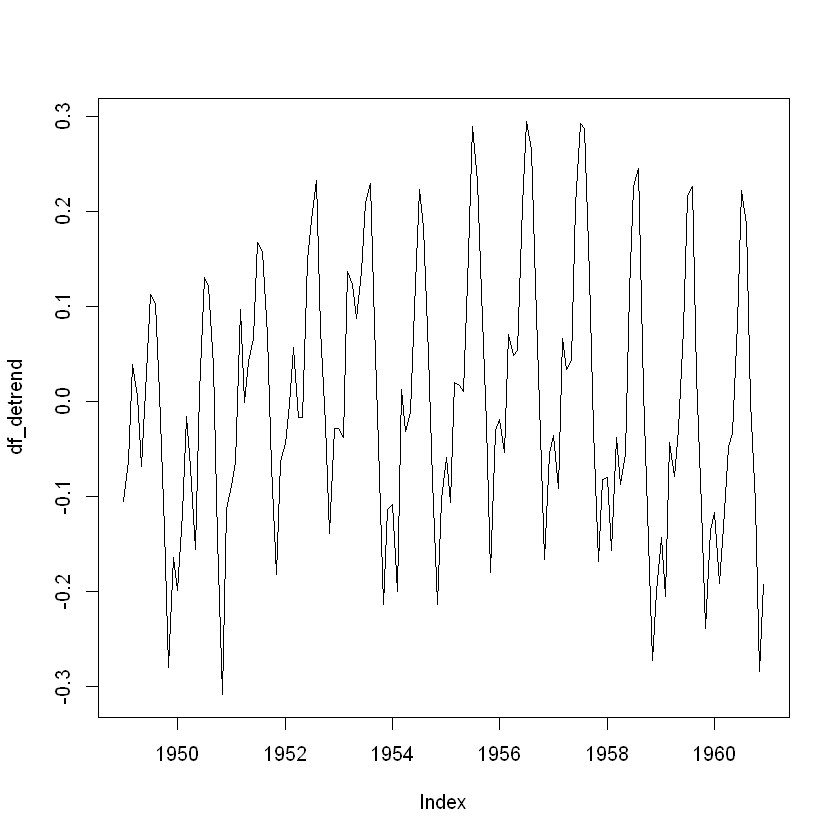

In [364]:
plot(df_detrend)

In [365]:
#fft_df = fft(diff(log(df$Passengers)))
fft_df = fft(df_detrend)
fft_df[1:10]

                 1949-01-01                  1949-02-01 
-2.042810e-14+0.000000e+00i -3.413459e+00+1.836112e-01i
                 1949-03-01                  1949-04-01 
-1.385319e+00-5.684846e-01i  1.836019e+00+1.359261e+00i
                 1949-05-01                  1949-06-01 
 8.815098e-02+2.633051e-02i  1.121880e-01+7.153653e-01i
                 1949-07-01                  1949-08-01 
 6.001707e-01-9.846591e-01i  2.247522e-02-5.483008e-01i
                 1949-09-01                  1949-10-01 
 2.532679e-01+4.666718e-01i  1.001089e-01-3.796122e-01i

In [366]:
n = length(fft_df)
periodogram = (abs(fft_df)^2)/n
periodogram = 4*periodogram[1:((n+1)/2)]

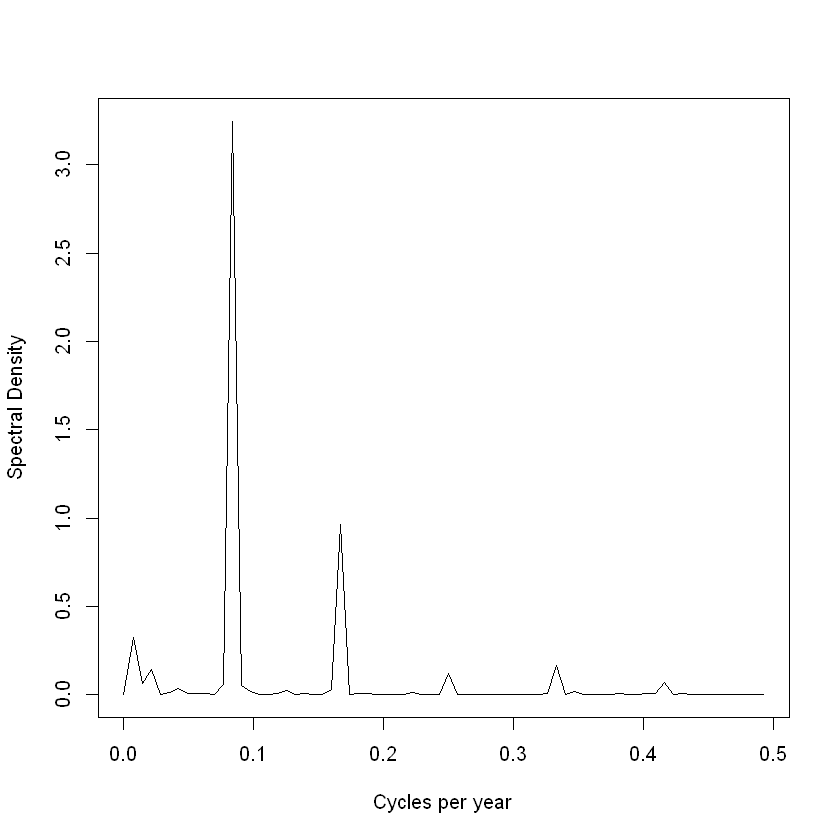

In [367]:
# frequency as cycles per year
spec_freq =(0:((n+1)/2-1))/n
spec_perdiodogram = periodogram
plot(spec_freq, spec_perdiodogram, xlab="Cycles per year", ylab="Spectral Density", type="l")

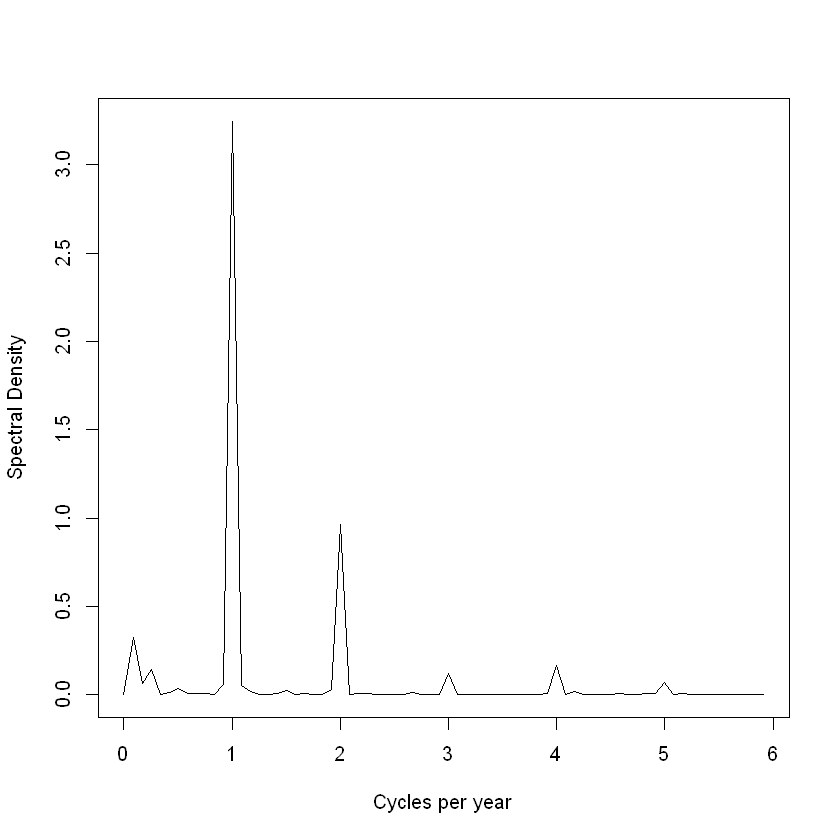

In [368]:
# frequency as cycles per year
sampling_freq = 12
spec_freq = sampling_freq * (0:((n+1)/2-1))/n
spec_perdiodogram = periodogram
plot(spec_freq, spec_perdiodogram, xlab="Cycles per year", ylab="Spectral Density", type="l")

In [354]:
class(df_detrend)

[1] "zoo"

In [355]:
class(df_2)

[1] "zoo"